# __Puffins__

## NB 03 - Tuning hyper-parameters

Now that we've seen how powerful this feature weighted regression model can be, we have some house-keeping to do.
While the model is as simple as it can be, there are still __some__ parameters that we can tune. In the case of a Ridge Regression, you have the penalty term &lambda;, and in the case of the feature weighted model you have the width, S, of the weighting term, which effectively acts as a kernel in our case.

In addition to this, both the period of the periodic signal and the number of harmonics in our Fourier basis can technically be optimised as hyper-parameters. While the number of harmonics is less important because of the feature weighting which naturally suppresses high frequency harmonics, the period is something that can benefit from being tuned as a hyperparameter. Furthermore, this cleverly allows us to avoid including this in the regression as a feature since the embedding depends on the period in a non-linear fashion!

There are several well-known methods for determining the optimal values of hyper-parameters in a model. In the case of U Gru, we're dealing with highly correlated data, and we're not exactly looking to predict or forecast the data into the future, so we can use tuning methods that don't explicitly test the time-series nature of the data. However, we can imagine scenarios in which we might want to, so we'll compare the outcomes for hyper-parameters tuned on our data ignoring and accounting for the time-series behaviour of our data. Additionally, there will be times where we work with non-uniformly sampled time-series data, so we'll also try using a K-Folds cross-validation routine inside our tuning loop. 


In [1]:
%matplotlib widget
import numpy as np
import matplotlib.pyplot as plt

from puffins.weight_functions import matern32
from puffins.basis_functions import basis_constant, basis_linear

from puffins.data import TimeSeries,LinearModel
from puffins.tuner import Tuner


np.random.seed(42) # to enforce reproducibility
RCOND = 1e-14 # numerical rounding for matrix conditioning
plotnum=1

Let's download / unpack the data

In [2]:
time, flux = np.loadtxt('../data/ugru.dat').T
period = 1.88045
n_harmonics = 100
feature_weighting_width = 0.5

## Un-tuned model
Now we're going to establish our "un-tuned" model and save it for later comparison.

In [3]:
data = TimeSeries(time, flux)
fwls = LinearModel('fw', basis_functions=[basis_constant,], feature_embedding='fourier', 
                   feature_weighting_function=matern32, feature_weighting_width=feature_weighting_width,
                   period=period, n_harmonics=100, W=None)

fwls.set_X_train(data.predictors)
fwls.train(data.targets)
untuned_model = fwls.trained_model
untuned_mse = fwls.trained_mse


## Tuning our model's hyperparameters

In this next step, we'll see how to tune the hyper-parameters of our model with a wrapper around optuna.

First, we need to make a dictionary of our hyperparameters, their ranges, and their distributions. 
Next, we instantiate our Tuner class, and then run the tuning!

In [4]:
joint_ = {'feature_weighting_width': [0.001,1,'uniform'], 'period': [1.87,1.89,'uniform']}
joint_tuner = Tuner(fwls, hyperpars=joint_, n_trials=200, direction='minimize')
joint_tuner.run_tune(data.predictors, data.targets)

[I 2025-02-04 11:37:20,802] A new study created in memory with name: no-name-b73e11c7-4286-47e6-9e3b-cf6590b0b115
[I 2025-02-04 11:37:20,863] Trial 0 finished with value: 0.010119634531753498 and parameters: {'feature_weighting_width': 0.9178755953668961, 'period': 1.8752686948078203}. Best is trial 0 with value: 0.010119634531753498.
[I 2025-02-04 11:37:20,928] Trial 1 finished with value: 0.0012117177520775985 and parameters: {'feature_weighting_width': 0.38374067666598255, 'period': 1.8827538248558622}. Best is trial 1 with value: 0.0012117177520775985.
[I 2025-02-04 11:37:20,984] Trial 2 finished with value: 0.004378065375338919 and parameters: {'feature_weighting_width': 0.5778373394753616, 'period': 1.8847496534453856}. Best is trial 1 with value: 0.0012117177520775985.
[I 2025-02-04 11:37:21,049] Trial 3 finished with value: 0.0034585968873955624 and parameters: {'feature_weighting_width': 0.5386784512644248, 'period': 1.8838208481860623}. Best is trial 1 with value: 0.001211717

Tuner:
 feature_weighting_width: 0.022900101756691424
period: 1.880457645139561


In [10]:
print(joint_tuner)

Tuner:
 feature_weighting_width: 0.022900101756691424
period: 1.880457645139561


## Updating the model

As we can see above, we've found the "optimal" values for the period and feature weighting width parameters in our model.
Now, we need to update the model to use these "optimal" values, and retrain our model with these values.

In [11]:
fwls.set_X_kwargs(update=True, **joint_tuner.best_hyperpars)
fwls.set_X_train(data.predictors)
fwls.train(data.targets)

## Model comparison

Now that we've gone through the trouble of tuning our hyper-parameters, we should take a look at the models to see if they're really that much better.

Text(0, 0.5, '(Predicted) Flux')

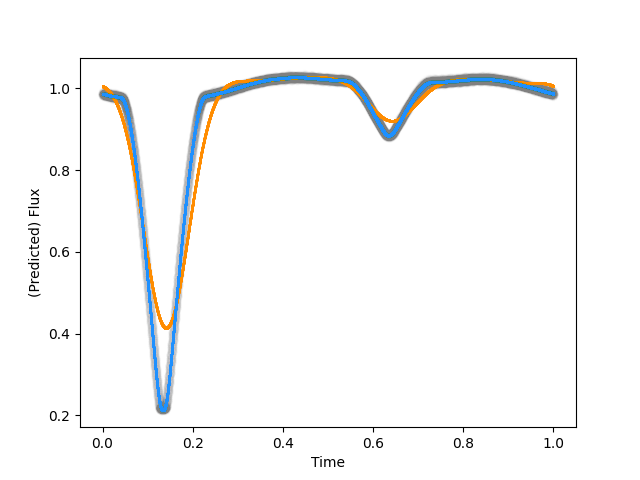

In [ ]:
plotnum += 1
fig_, ax_ = plt.subplots(num=plotnum)
ph_untuned = data.predictors / period % 1
ph_tuned = data.predictors / fwls.X_kwargs['period'] % 1
ax_.plot(ph_tuned, data.targets, 'o', color='grey', alpha=0.01)
ax_.plot(ph_untuned, untuned_model, '+', ms=1.5, color='darkorange', alpha=0.85)
ax_.plot(ph_tuned, fwls.trained_model, 'x', ms=1.5, color='dodgerblue')
ax_.set_xlabel('Time')
ax_.set_ylabel('(Predicted) Flux')

Clearly, the tuning was worthwhile! 
As a note on treating the period of the seasonal trend as a hyper-parameter, I'd like to point out that we used a fairly narrow range over which we tuned the value. In some other tests, it does a good job of finding the optimal value over a much larger range, but this is __not__ a general behaviour. Specifically, in cases where the range encompases the first harmonic of the period (=1/2 * period), then the model can bifurcate between these values. As a rule of thumb, you'll often have a pretty decent idea of what the period is with some small uncertainty range, so I would suggest keeping the tuning range as small as you can reasonably manage. 

## Other notes

Although we jointly tuned the period and feature_weighting_width values, in some cases it may be beneficial to tune each individually. In these cases, you can easily do this by declaring indiviaul tuners and updating the LinearModel inbetween tuning runs, e.g.:

period_ = {'period': [1.87,1.89,'uniform']}
width_ = {'feature_weighting_width': [0.001,1.,'uniform']}

period_tuner = Tuner( fwls, hyperpars=period_, n_trials=200, direction='minimize')
period_tuner.run_tune(time, flux)
print(period_tuner.best_hyperpars)
fwls.set_X_kwargs(update=True, period=period_tuner.best_hyperpars['period'])

width_tuner = Tuner( fwls, hyperpars=width_, n_trials=50, direction='minimize')
width_tuner.run_tune(time, flux)

fwls.set_X_kwargs(update=True, feature_weighting_width=width_tuner.best_hyperpars['feature_weighting_width'])

fwls.set_X_train(data.predictors)
fwls.train(data.targets)
